CS5100 Foundations of Artificial Intelligence Project 
Author: Arun Madhusudhanan, Tejaswini Dilip Deore

This script is used to fine tune ViT - GPT2 model on Flickr8k dataset

In [ ]:
# Install the required libraries for google colab
!pip install datasets
!pip install transformers==4.17
!pip install accelerate -U
!pip install evaluate
!pip install rouge_score

In [ ]:
# Import the required libraries
import os
import datasets
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer
os.environ["WANDB_DISABLED"] = "true"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a symbolic link to the google drive
!ln -s /content/drive/My\ Drive/ /mydrive
!ls /mydrive

 04379243.zip		 FlowNet2_checkpoint.pth.tar	  'My Drive'
 Ambush-2_updated.zip	 flow.zip			   scripts.zip
 ambush_6_png.zip	 GRNet-ShapeNet.pth		   ShapeNetCompletion.zip
 ambush_6.zip		 Image_captioning		   shapenet_PN2_partial.zip
'Colab Notebooks'	 inference.zip			   shapenet_PN2.zip
 Deep_Image_Captioning	 modelnet40_normal_resampled.zip   video3.mp4


In [ ]:
# Copy the dataset to the colab
!cp -r /mydrive/Image_captioning/Images.zip /content/

In [ ]:
#copy the dataset to the colab
!cp -r /mydrive/Image_captioning/captions.txt.zip /content/

In [ ]:
# Unzip the images
!unzip /content/Images.zip -d /content/Images

In [ ]:
# Unzip the captions
!unzip /content/captions.txt.zip -d /content/

In [ ]:
# Import the required libraries
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer

# Load the pretrained models from huggingface
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

# create a vision encoder decoder model using the pretrained models
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.6.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.9.crossattention.c_proj.weight', 'h.11.crossattention.masked_bias', 'h.9.crossattention.c_proj.bias', 'h.11.crossattention.c_proj.bias', 'h.8.crossattention.masked_bias', 'h.11.ln_cross_attn.weight', 'h.0.ln_cross_attn.weight', 'h.10.crossattention.q_attn.weight', 'h.11.crossattention.bias', 'h.3.crossattention.masked_bias', 'h.0.crossattention.masked_bias', 'h.0.crossattention.q_attn.weight', 'h.0.crossattention.bias', 'h.6.crossattention.bias', 'h.5.crossattention.masked_bias', 'h.2.ln_cross_attn.weight', 'h.5.crossattention.bias', 'h.9.crossattention.masked_bias', 'h.8.crossattention.q_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.3.ln_cross_attn.weight', 'h.5.crossattention.q_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.9.crossattention.bias', '

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

# Load the feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# define tokens to be used for image features and text
tokenizer.pad_token = tokenizer.eos_token # set the pad token to be the same as the eos token for GPT2

# set the special tokens for the model
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
# Save the pretrained model to the current directory
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)

In [ ]:
# use pandas to read the captions and images
image_data_location = "Images"
caption_data_location = "captions.txt"

df = pd.read_csv(caption_data_location)
# generate a new df with image and caption but image only represented once and adjust index
df = df.drop_duplicates(subset='image')
df = df.reset_index(drop=True)

df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [ ]:
from PIL import Image

def tokenization_fn(captions,max_target_length):
    labels = tokenizer(captions, padding="max_length", max_length=max_target_length).input_ids
    return labels

def feature_extraction_fn(images):
    return feature_extractor(images, return_tensors="np").pixel_values

def preprocess_fn(images, captions, max_target_length, image_dir=image_data_location):
    image_path = image_dir + "/" + images
    img = Image.open(image_path).convert("RGB")
    return {"labels": tokenization_fn(captions,max_target_length), "pixel_values": feature_extraction_fn(img)}

print(df["image"][5], df["caption"][5])
model_inputs = preprocess_fn(df["image"][5], df["caption"][5], 32)
print(model_inputs["pixel_values"].shape)




1007320043_627395c3d8.jpg A child playing on a rope net .
(1, 3, 224, 224)


In [ ]:
# Utility functions to generate the dataset

from datasets import Dataset
import torch
import numpy
from tqdm import trange


train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

def train_data_generator():
    for i in range(train_size):
        model_inputs = preprocess_fn(train_df["image"][i], train_df["caption"][i], 40)
        yield {"labels": model_inputs["labels"], "pixel_values": model_inputs["pixel_values"].squeeze()}

def test_data_generator():
    for i in range(train_size, len(df)):
        model_inputs = preprocess_fn(test_df["image"][i], test_df["caption"][i], 40)
        yield {"labels": model_inputs["labels"], "pixel_values": model_inputs["pixel_values"].squeeze()}

train_dataset = Dataset.from_generator(train_data_generator)
test_dataset = Dataset.from_generator(test_data_generator)


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Define the training arguments for finetuning the model
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
    num_train_epochs=3,
    save_strategy="epoch",
    save_total_limit=1
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
import evaluate
metric = evaluate.load("rouge")


In [ ]:
import numpy as np
import nltk
nltk.download('punkt')

ignore_pad_token_for_loss = True

# Define the post processing function
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

# Define the compute metrics function to compute the rouge score
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from transformers import default_data_collator

# instantiate trainer with the training arguments
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=default_data_collator
)


In [ ]:
# Train the model
trainer.train()

In [ ]:
trainer.save_model("./image-captioning-output") # Save the model

Saving model checkpoint to ./image-captioning-output
Configuration saved in ./image-captioning-output/config.json
Model weights saved in ./image-captioning-output/pytorch_model.bin
Feature extractor saved in ./image-captioning-output/preprocessor_config.json


In [ ]:
tokenizer.save_pretrained("./image-captioning-output") # Save the tokenizer

tokenizer config file saved in ./image-captioning-output/tokenizer_config.json
Special tokens file saved in ./image-captioning-output/special_tokens_map.json


('./image-captioning-output/tokenizer_config.json',
 './image-captioning-output/special_tokens_map.json',
 './image-captioning-output/vocab.json',
 './image-captioning-output/merges.txt',
 './image-captioning-output/added_tokens.json',
 './image-captioning-output/tokenizer.json')

<|endoftext|>A black dog is jumping through the water carrying a stick.<|endoftext|>


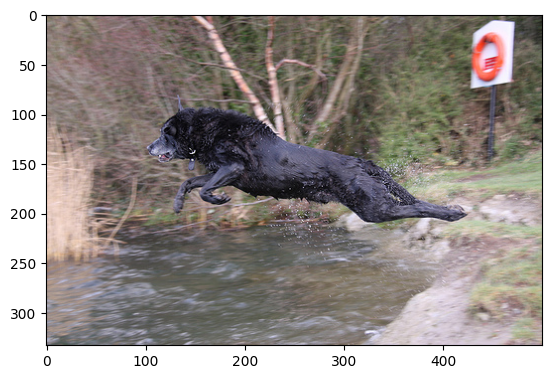

In [ ]:
# Load the model and check the output for a sample image
image_path = image_data_location + "/" + df["image"][1008]
img = Image.open(image_path).convert("RGB")
plt.imshow(mpimg.imread(image_path))

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values.to("cuda"))

generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(generated_text)